# Demo of Predictive State Smoothing (PRESS)

PRESS is a kernel smoothing technique for any type of predictive learning problem (classification, regression, ...).

This notebook shows examples of how to use the main functionality for a regression and classification problem.  Core PRESS functionality and layers, though, can be used for any learning problem with non-standard activation functions.

See also


* Goerg (2018) *[Classification using Predictive State Smoothing (PRESS): A scalable kernel classifier for high-dimensional features with variable selection](https://research.google/pubs/pub46767/)*.

* Goerg (2017) *[Predictive State Smoothing (PRESS): Scalable non-parametric regression for high-dimensional data with variable selection](https://research.google/pubs/pub46141/).*


Make sure you have your `.venv` enabled and the notebook kernel is running from that virtual environment, e.g.,
```
source .venv/bin/activate
```


In [1]:
%load_ext autoreload
%load_ext tensorboard
%autoreload 2

In [2]:
import importlib
import tensorflow as tf

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

In [3]:
from pypress.keras import layers
from pypress.keras import initializers
from pypress.keras import regularizers
from pypress.keras import activations
from pypress import clustering
from pypress import utils

# Utility functions and setup

In [4]:
# misc helper functions
from typing import Tuple, Any
import sklearn
import sklearn.model_selection
from sklearn.preprocessing import RobustScaler


def _get_loss_activation_metrics(y: pd.Series) -> Tuple[Any, Any, Any]:

    if len(np.unique(y)) == 2:
        act = "sigmoid"
        loss_fn = "binary_crossentropy"
        metrics = [tf.keras.metrics.AUC(curve="PR", name="aupr"), tf.keras.metrics.AUC(curve="ROC", name="auc_roc")]
    elif len(np.unique(y)) <  11:#isinstance(y.iloc[0], str):
        act = "softmax"
        loss_fn = "sparse_categorical_crossentropy"
        metrics = [tf.keras.metrics.CategoricalAccuracy()]
    else:
        act = "linear"
        loss_fn = "mse"
        metrics = [tf.keras.metrics.RootMeanSquaredError()]
        
        if (y >= 0.).all():
            act = "softplus"
            loss_fn = "mse"

    return (loss_fn, act, metrics)


def _get_recommended_callbacks():
    logdir = "logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    print(logdir)
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1)
    return [tf.keras.callbacks.EarlyStopping(patience=10),
                             tensorboard_callback], logdir


def _scale_df(X, scaler = None):
    
    if scaler is None:
        scaler = RobustScaler()
        scaler.fit(X)
    return pd.DataFrame(scaler.transform(X), columns=X.columns, index=X.index), scaler


def _train_test_scale(X, y):
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2)
    
    X_train_s, scaler = _scale_df(X_train, None)
    X_test_s, scaler = _scale_df(X_test, scaler)
    
    return (X_train, y_train, X_test, y_test), scaler


# Classification

In [5]:
from sklearn.datasets import load_breast_cancer
X, y = load_breast_cancer(return_X_y=True, as_frame=True)

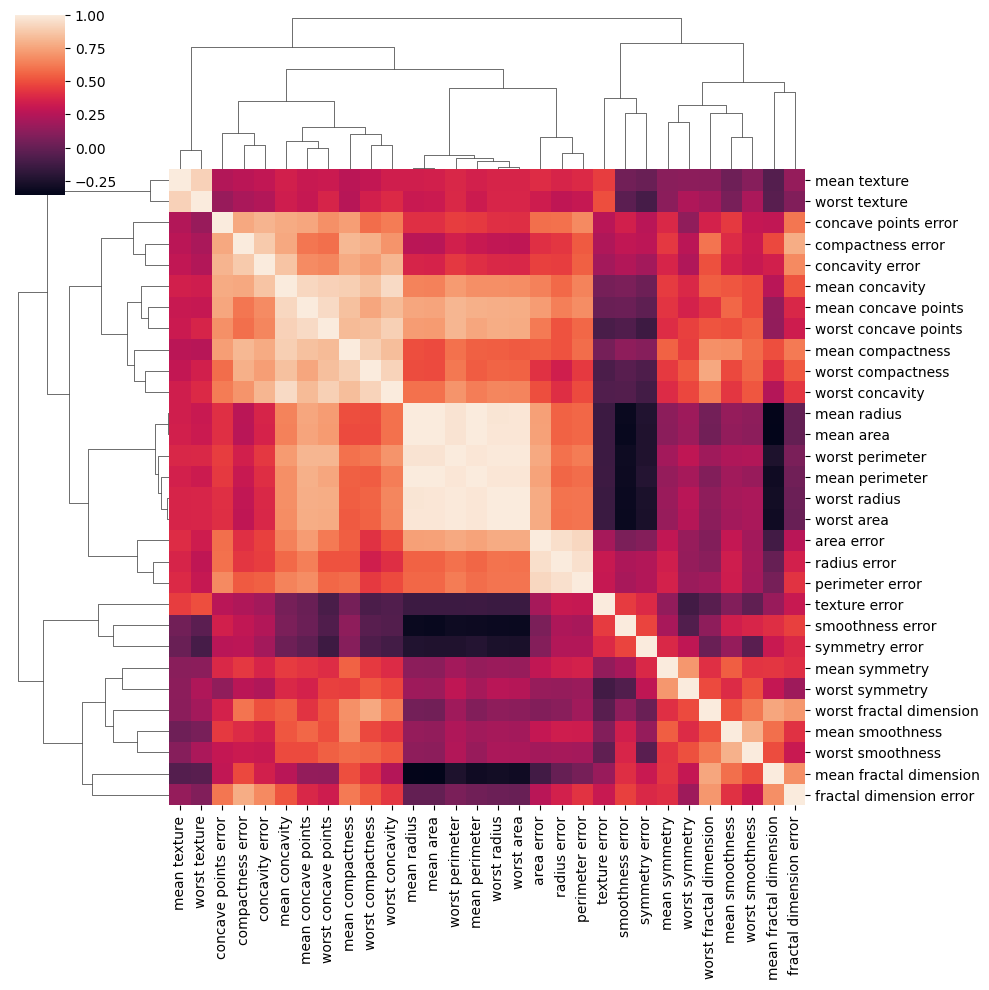

In [6]:
sns.clustermap(X.corr("spearman"))

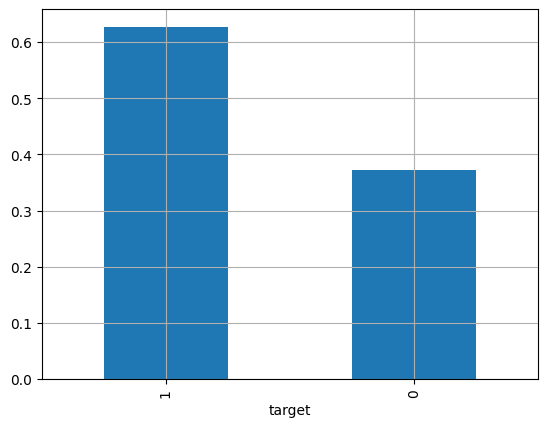

In [7]:
y.value_counts(normalize=True).plot.bar()
plt.grid()

In [8]:
scaled_data, sc = _train_test_scale(X, y)
X_tr, y_tr, X_ts, y_ts = scaled_data
X_tr.shape, X_ts.shape

((455, 30), (114, 30))

In [9]:
loss_fn, act, metrics = _get_loss_activation_metrics(y)

feat_input = tf.keras.layers.Input(shape=(X.shape[1],))

feat_eng_layer = tf.keras.Sequential()
feat_eng_layer.add(tf.keras.layers.Dense(50, "selu"))
feat_eng_layer.add(tf.keras.layers.Dropout(0.25))
feat_eng_layer.add(tf.keras.layers.BatchNormalization())
feat_eng_layer.add(tf.keras.layers.Dense(30, "tanh"))
feat_eng_layer.add(tf.keras.layers.Dropout(0.25))
feat_eng_layer.add(tf.keras.layers.BatchNormalization())

hidden = feat_eng_layer(feat_input)
pred_states = layers.PredictiveStateSimplex(n_states=5, activity_regularizer=regularizers.Uniform(10.))(hidden)
pred = layers.PredictiveStateMeans(units=1, activation=act)(pred_states)

mod = tf.keras.Model(inputs=feat_input, outputs=pred)
mod.compile(loss=loss_fn, optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001),
            metrics=metrics)
mod.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 30)             │         3,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictive_state_simplex        │ (None, 5)              │           155 │
│ (PredictiveStateSimplex)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictive_state_means          │ (None, 1)              │             5 │
│ (PredictiveStateMeans)          │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,560 (13.91 KB)

 Trainable params: 3,400 (13.28 KB)

 Non-trainable params: 160 (640.00 B)

In [10]:
clbks, logdir_str = _get_recommended_callbacks()

logs/20251229-172214


In [11]:
history = mod.fit(X_tr, y_tr, epochs=30, 
                  validation_data=(X_ts, y_ts),
                  callbacks=clbks,
                 )

Epoch 1/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc_roc: 0.6945 - aupr: 0.8001 - loss: 0.6732 - val_auc_roc: 0.8968 - val_aupr: 0.9187 - val_loss: 0.6890
Epoch 2/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - auc_roc: 0.8916 - aupr: 0.9202 - loss: 0.6756 - val_auc_roc: 0.9169 - val_aupr: 0.9227 - val_loss: 0.6855
Epoch 3/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - auc_roc: 0.8811 - aupr: 0.9244 - loss: 0.6687 - val_auc_roc: 0.9006 - val_aupr: 0.8870 - val_loss: 0.6846
Epoch 4/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - auc_roc: 0.8757 - aupr: 0.9154 - loss: 0.6703 - val_auc_roc: 0.9320 - val_aupr: 0.9259 - val_loss: 0.6845
Epoch 5/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - auc_roc: 0.9165 - aupr: 0.9419 - loss: 0.6697 - val_auc_roc: 0.9122 - val_aupr: 0.9018 - val_loss: 0.6844
Epoch 6/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - auc_roc: 0.8853 - aupr: 0.9225 - loss: 0.6621 - val_auc_roc: 0.9290 - val_aupr: 0.9268 - val_loss: 0.6847
Epoch 7/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step -

In [12]:
# %tensorboard --logdir $logdir_str

In [13]:
preds = pd.DataFrame({"true": y_ts, "pred": mod.predict(X_ts, verbose=False).ravel()})

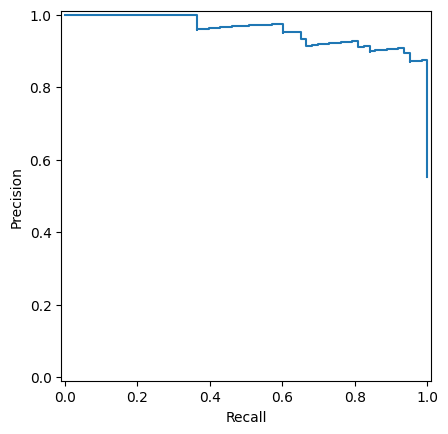

In [14]:
from sklearn.metrics import (precision_recall_curve, PrecisionRecallDisplay)
precision, recall, _ = precision_recall_curve(preds["true"], preds["pred"])
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()


(114, 30)


<Axes: >

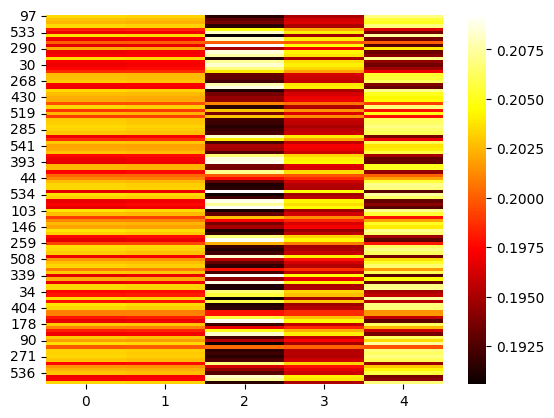

In [15]:
state_mapping = tf.keras.Model(inputs=feat_input, outputs=pred_states)
print(X_ts.shape)
pred_emb = pd.DataFrame(state_mapping(X_ts.values).numpy(), index=X_ts.index)
sns.heatmap(pred_emb, cmap="hot")

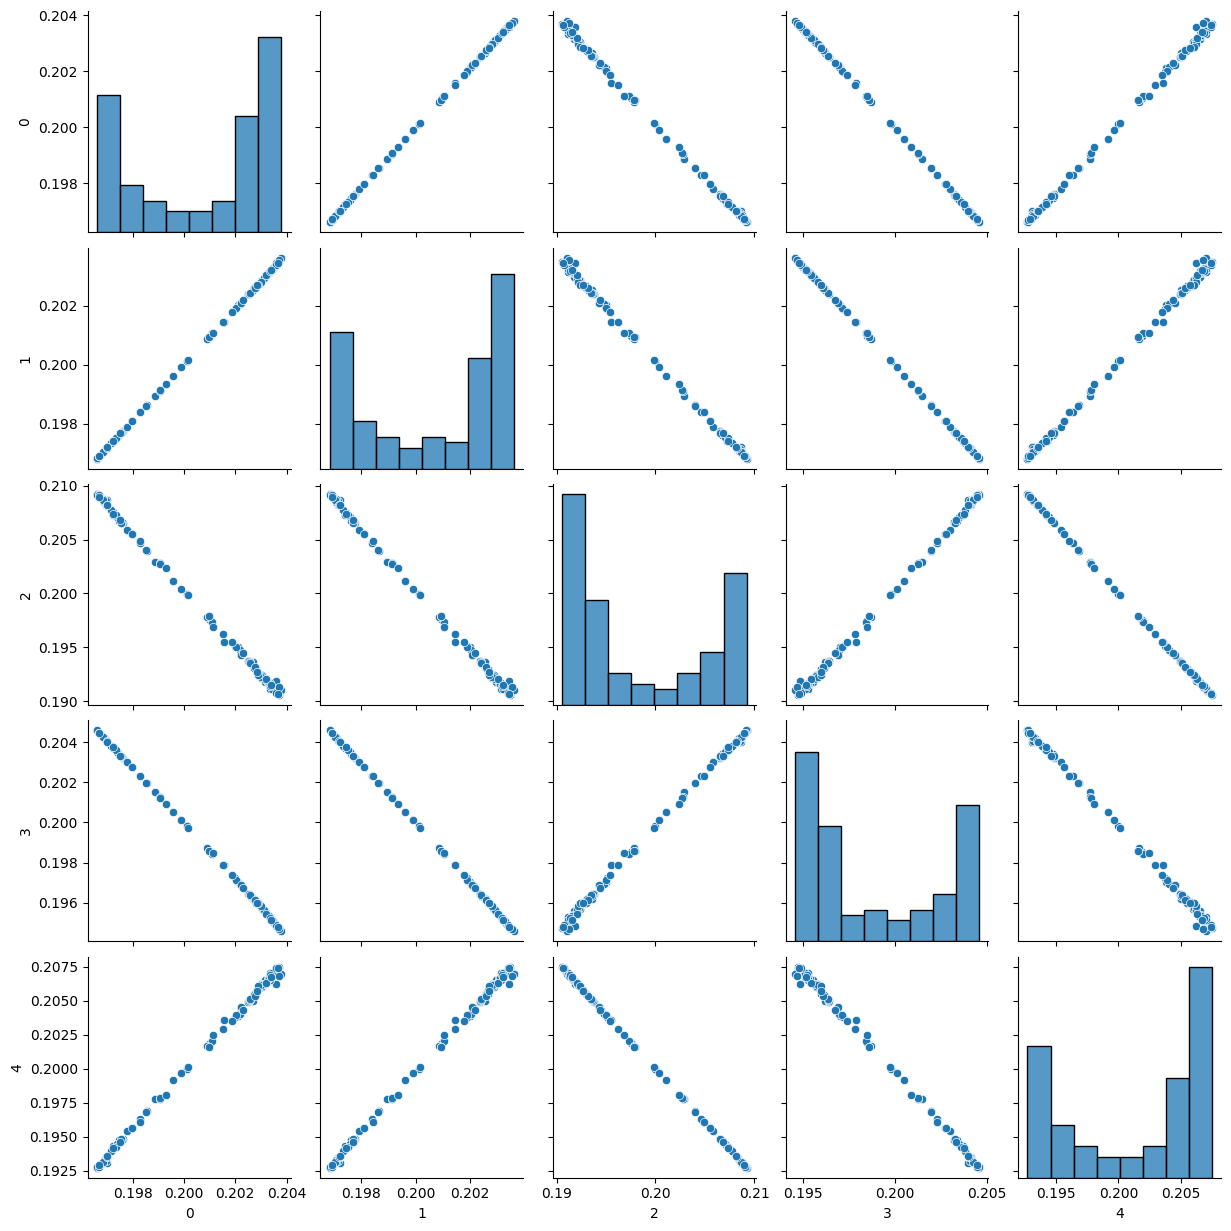

In [16]:
sns.pairplot(pred_emb)

In [17]:
X_state = utils.agg_data_by_state(X_ts, pred_emb)
X_state

,0,1,2,3,4
mean radius,14.635553,14.638095,14.789634,14.737008,14.591030
mean texture,19.507791,19.509003,19.578144,19.553040,19.486359
mean perimeter,95.611573,95.629200,96.679869,96.314737,95.302665
mean area,704.741445,704.993835,719.962808,714.733054,700.325429
mean smoothness,0.095378,0.095381,0.095551,0.095490,0.095328
mean compactness,0.110871,0.110896,0.112418,0.111882,0.110418
mean concavity,0.101437,0.101479,0.104009,0.103120,0.100688
mean concave points,0.053807,0.053833,0.055385,0.054841,0.053349
mean symmetry,0.181433,0.181439,0.181776,0.181654,0.181330
mean fractal dimension,0.062633,0.062632,0.062572,0.062591,0.062650


In [18]:
mod.layers[-1].state_conditional_means.numpy()

array([[0.6875165 ],
       [0.68258166],
       [0.33375365],
       [0.42448124],
       [0.767096  ]], dtype=float32)

In [19]:
utils.state_size(pred_emb, normalize=True)

state
0    0.200772
1    0.200739
2    0.198283
3    0.198849
4    0.201357
dtype: float32

In [20]:
X_state

state,0,1,2,3,4
mean radius,14.635553,14.638095,14.789634,14.737008,14.591030
mean texture,19.507791,19.509003,19.578144,19.553040,19.486359
mean perimeter,95.611573,95.629200,96.679869,96.314737,95.302665
mean area,704.741445,704.993835,719.962808,714.733054,700.325429
mean smoothness,0.095378,0.095381,0.095551,0.095490,0.095328
mean compactness,0.110871,0.110896,0.112418,0.111882,0.110418
mean concavity,0.101437,0.101479,0.104009,0.103120,0.100688
mean concave points,0.053807,0.053833,0.055385,0.054841,0.053349
mean symmetry,0.181433,0.181439,0.181776,0.181654,0.181330
mean fractal dimension,0.062633,0.062632,0.062572,0.062591,0.062650


<Axes: >

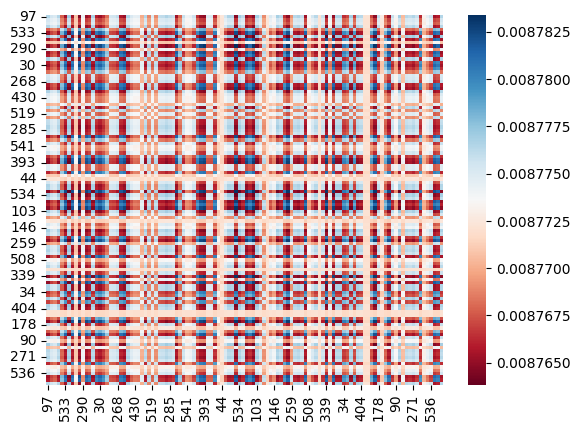

In [22]:
sns.heatmap(utils.kernel_matrix(pred_emb), cmap="RdBu")

In [23]:
pred_fn = lambda x: mod.predict(x)[:, 0]

In [24]:
import shap
# build a Permutation explainer and explain the model predictions on the given dataset
explainer = shap.explainers.Permutation(pred_fn, X_ts)
explainer.feature_names

/Users/georg/Projects/pypress/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [25]:
shap_values = explainer(X_ts.iloc[:20])  # ~20sec

189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 286us/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 226us/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 203us/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 235us/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 231us/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 243us/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 228us/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 239us/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
189/189 ━━━━━

PermutationExplainer explainer:  50%|█████     | 10/20 [00:00<?, ?it/s]

189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 241us/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step


PermutationExplainer explainer:  60%|██████    | 12/20 [00:10<00:02,  2.74it/s]

189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 238us/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 230us/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 239us/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 282us/step


PermutationExplainer explainer:  65%|██████▌   | 13/20 [00:11<00:03,  2.00it/s]

189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 300us/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step


PermutationExplainer explainer:  70%|███████   | 14/20 [00:12<00:03,  1.68it/s]

189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 190us/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 193us/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 203us/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 189us/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 203us/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step


PermutationExplainer explainer:  75%|███████▌  | 15/20 [00:12<00:03,  1.65it/s]

189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 192us/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 557us/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 191us/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 208us/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 239us/step


PermutationExplainer explainer:  80%|████████  | 16/20 [00:13<00:02,  1.56it/s]

189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 379us/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step


PermutationExplainer explainer:  85%|████████▌ | 17/20 [00:14<00:02,  1.42it/s]

189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 232us/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 230us/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 243us/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step


PermutationExplainer explainer:  90%|█████████ | 18/20 [00:15<00:01,  1.32it/s]

189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 233us/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 226us/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 380us/step


PermutationExplainer explainer:  95%|█████████▌| 19/20 [00:16<00:00,  1.21it/s]

189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 229us/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step


PermutationExplainer explainer: 100%|██████████| 20/20 [00:17<00:00,  1.19it/s]

189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 242us/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step


PermutationExplainer explainer: 21it [00:17,  1.63s/it]                        


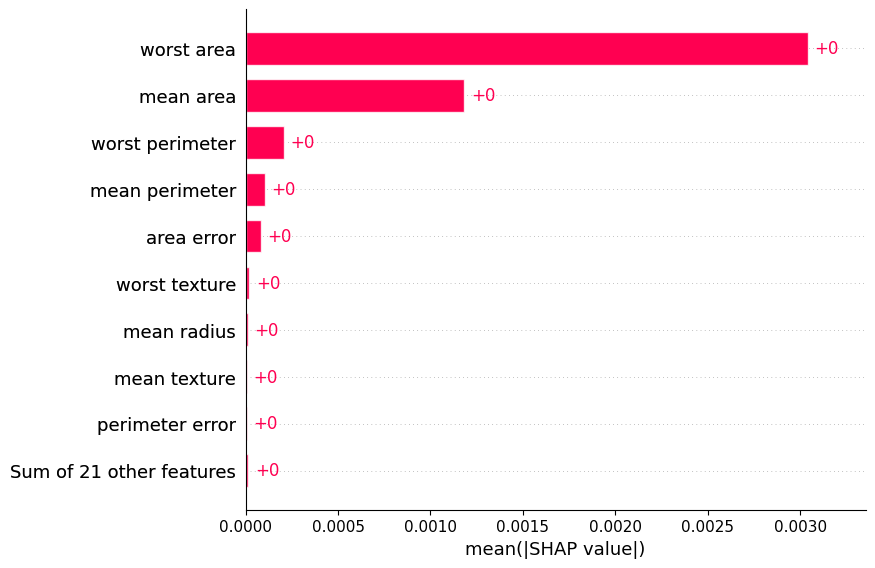

In [26]:
shap.plots.bar(shap_values)

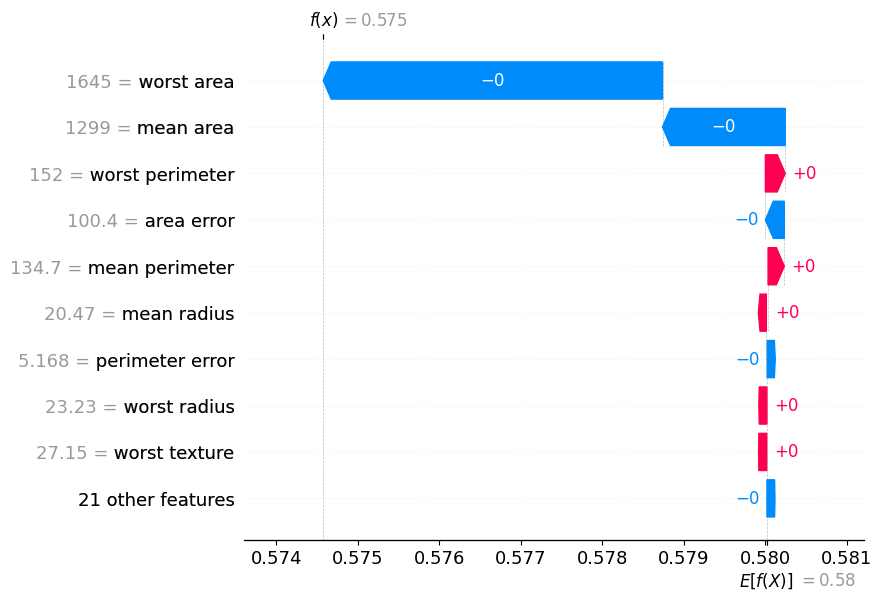

In [27]:
shap.plots.waterfall(shap_values[5])

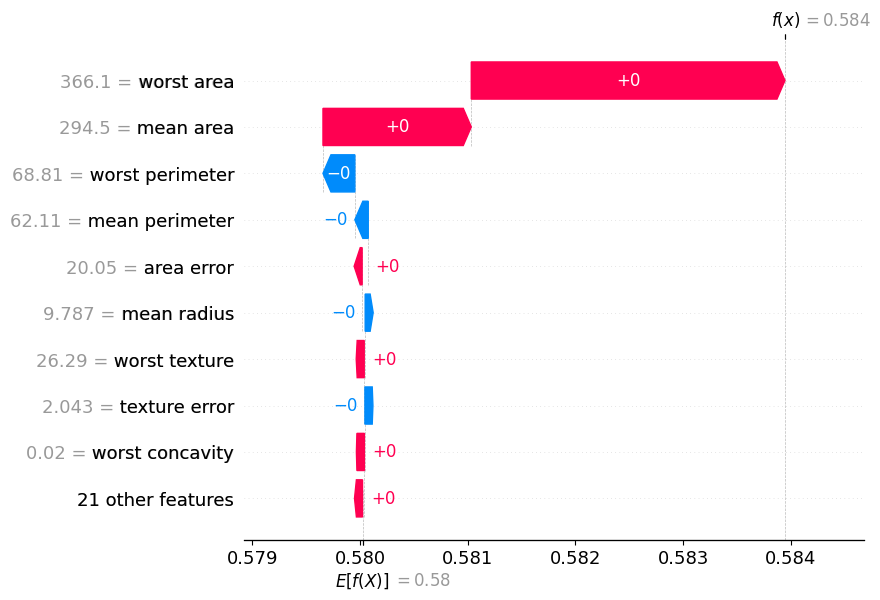

In [28]:
shap.plots.waterfall(shap_values[0])

# Regression


In [ ]:
if False: # issues downloading data (https://github.com/scikit-learn/scikit-learn/issues/28297)
    from sklearn.datasets import fetch_california_housing
    housing = fetch_california_housing(as_frame=True)

    X, y = housing["data"], housing["target"]
    X.shape, y.shape

In [29]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.california_housing.load_data(
    version="large", path="california_housing.npz", test_split=0.2, seed=113
)

In [30]:
# TODO: make sure order is correct
feature_names = [ 
     'longitude',
 'latitude',
  'houseage',
 'medinc',
'avebedrms',
 'averooms',
 'population',
 'aveoccup',]



In [31]:
x_train_df = pd.DataFrame(x_train, columns=feature_names)
x_test_df = pd.DataFrame(x_test, columns=feature_names)

y_train_df = pd.Series(y_train, name="house_value")
y_test_df = pd.Series(y_test, name="house_value")

X = pd.concat([x_train_df, x_test_df], axis=0)
y = pd.concat([y_train_df, y_test_df], axis=0)

y = y / 1e3 # in thousand $

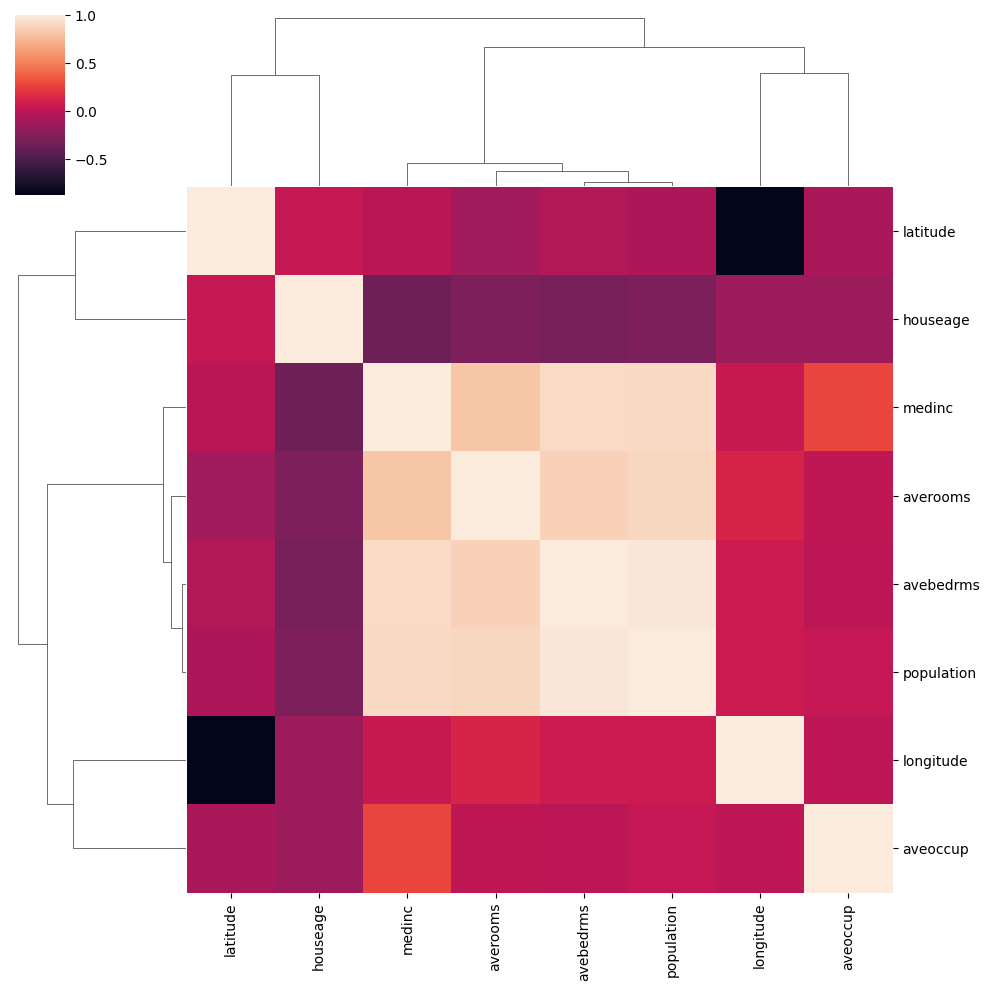

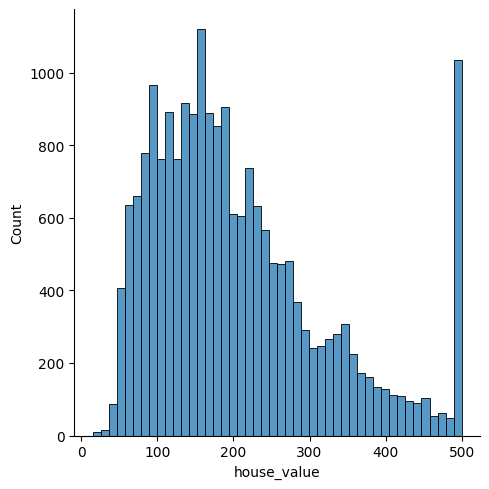

In [32]:
sns.clustermap(X.corr("spearman"))
plt.show()
sns.displot(y)

In [33]:
y_max = np.floor(y.max())
print("Max y value", y_max)

X = X.loc[y < y_max]
y = y.loc[y < y_max]

X.shape, y.shape

Max y value 500.0


((19648, 8), (19648,))

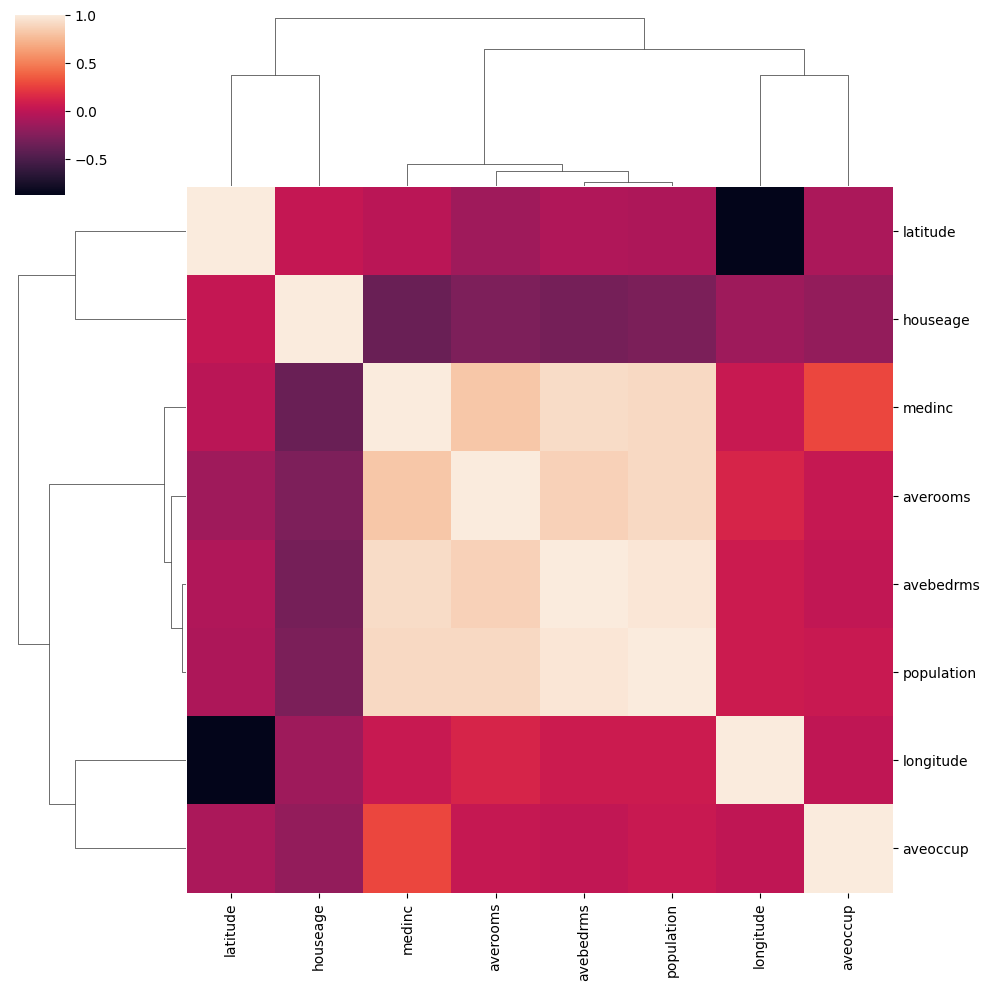

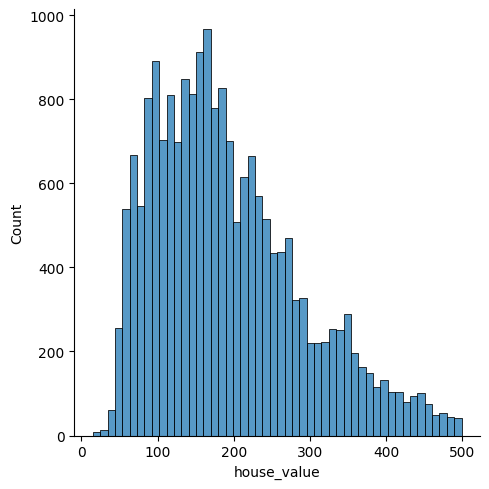

In [34]:
sns.clustermap(X.corr("spearman"))
plt.show()
sns.displot(y)

In [35]:
scaled_data, sc = _train_test_scale(X, y)
X_tr, y_tr, X_ts, y_ts = scaled_data
X_tr.shape

(15718, 8)

<Axes: >

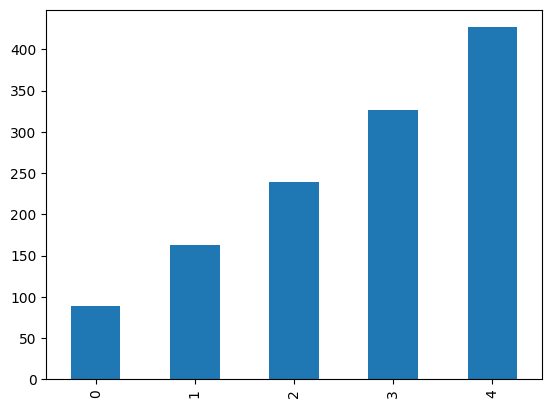

In [38]:
# Let's initialize state means from data
init_values_gmm = utils.initialize_from_y(y.values, n_states=5)
pd.Series(init_values_gmm.ravel()).plot.bar()


In [41]:
loss_fn, act, metrics = _get_loss_activation_metrics(y_ts)
print(act, loss_fn)

softplus mse


In [42]:
# pass it to layer as example and see trainable params
ll = layers.PredictiveStateMeans(units=1, activation=act, init_values=init_values_gmm)
ll.build([10, 5])

In [43]:
ll._state_conditional_mean_logits

<Variable path=predictive_state_means_2/state_conditional_mean_logits, shape=(5, 1), dtype=float32, value=[[ 89.36059]
 [162.70882]
 [238.90283]
 [327.07303]
 [426.58035]]>

In [44]:
feat_input = tf.keras.layers.Input(shape=(X_tr.shape[1],))

feat_eng_layer = tf.keras.Sequential()
feat_eng_layer.add(tf.keras.layers.Dense(40, "relu", kernel_regularizer=tf.keras.regularizers.L2(0.001)))
feat_eng_layer.add(tf.keras.layers.Dropout(0.25))
feat_eng_layer.add(tf.keras.layers.BatchNormalization())
feat_eng_layer.add(tf.keras.layers.Dense(30, "swish", kernel_regularizer=tf.keras.regularizers.L2(0.001)))
feat_eng_layer.add(tf.keras.layers.Dropout(0.25))
feat_eng_layer.add(tf.keras.layers.BatchNormalization())
feat_eng_layer.add(tf.keras.layers.Dense(20, "tanh", kernel_regularizer=tf.keras.regularizers.L2(0.001)))
feat_eng_layer.add(tf.keras.layers.Dropout(0.25))
feat_eng_layer.add(tf.keras.layers.BatchNormalization())

hidden = feat_eng_layer(feat_input)
eps_mapping = layers.PredictiveStateSimplex(n_states=5, activity_regularizer=regularizers.Uniform(l1=0.1),
                                            kernel_regularizer=tf.keras.regularizers.l2(0.001))
pred_states = eps_mapping(hidden)
state_mean_layer = layers.PredictiveStateMeans(units=1, activation=act, init_values=init_values_gmm)
pred = state_mean_layer(pred_states)

mod = tf.keras.Model(inputs=feat_input, outputs=pred)
mod.compile(loss=loss_fn, optimizer=tf.keras.optimizers.Nadam(learning_rate=0.01),
            metrics=metrics)
mod.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 20)             │         2,570 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictive_state_simplex_1      │ (None, 5)              │           105 │
│ (PredictiveStateSimplex)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictive_state_means_3        │ (None, 1)              │             5 │
│ (PredictiveStateMeans)          │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,680 (10.47 KB)

 Trainable params: 2,500 (9.77 KB)

 Non-trainable params: 180 (720.00 B)

In [45]:
eps_mapping.trainable_weights

[<Variable path=predictive_state_simplex_1/kernel, shape=(20, 5), dtype=float32, value=[[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]>,
 <Variable path=predictive_state_simplex_1/bias, shape=(5,), dtype=float32, value=[0. 0. 0. 0. 0.]>]

In [46]:
state_mean_layer.trainable_variables

[<Variable path=predictive_state_means_3/state_conditional_mean_logits, shape=(5, 1), dtype=float32, value=[[ 89.36059]
  [162.70882]
  [238.90283]
  [327.07303]
  [426.58035]]>]

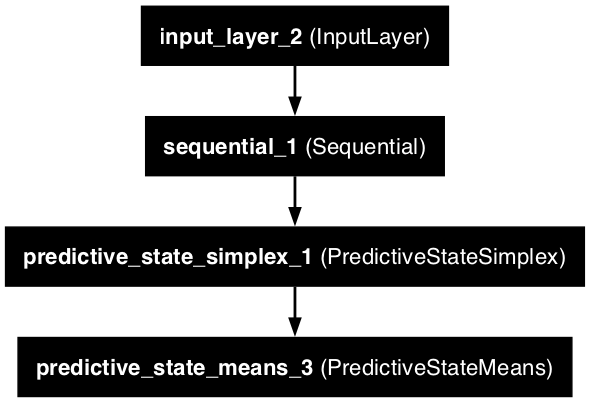

In [48]:
tf.keras.utils.plot_model(mod, dpi=100, show_layer_names=True)

In [50]:
history = mod.fit(X_tr, y_tr, epochs=50, batch_size=32,
                  validation_data=(X_ts, y_ts),
                  callbacks=[],#_get_recommended_callbacks()
                 )

Epoch 1/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 7400.5332 - root_mean_squared_error: 85.9947 - val_loss: 7117.7749 - val_root_mean_squared_error: 84.3464
Epoch 2/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step - loss: 7608.1885 - root_mean_squared_error: 87.1954 - val_loss: 6530.1924 - val_root_mean_squared_error: 80.7870
Epoch 3/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step - loss: 6947.6206 - root_mean_squared_error: 83.3177 - val_loss: 7943.4165 - val_root_mean_squared_error: 89.1044
Epoch 4/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step - loss: 7218.9351 - root_mean_squared_error: 84.9321 - val_loss: 7333.6050 - val_root_mean_squared_error: 85.6126
Epoch 5/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step - loss: 6861.4502 - root_mean_squared_error: 82.7947 - val_loss: 6210.1128 - val_root_mean_squared_error: 78.7767
Epoch 6/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 661us/step - loss: 6757.5986 - root_mean_squared_error: 82.1732 - val_loss: 6447.2026 - val_root_mean_squared_error: 80

In [51]:
mod.layers[-1].state_conditional_means.numpy().ravel()

array([100.670975, 137.36592 , 238.01205 , 310.55322 , 420.2681  ],
      dtype=float32)

<Axes: >

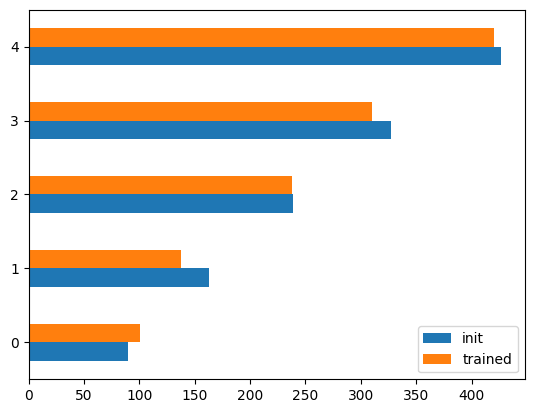

In [52]:
# Compare to original
pd.DataFrame({"init": init_values_gmm.ravel(),
              "trained": mod.layers[-1].state_conditional_means.numpy().ravel()}).plot.barh()

<Axes: >

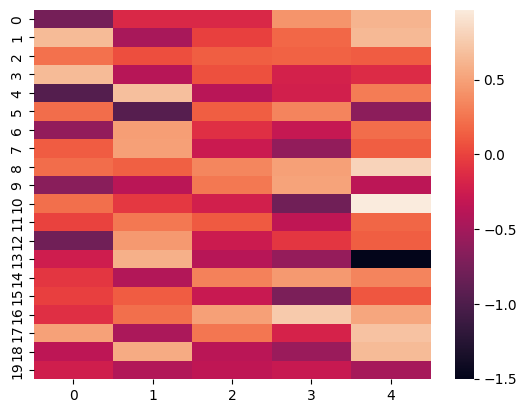

In [53]:
sns.heatmap(eps_mapping.trainable_weights[0].numpy())

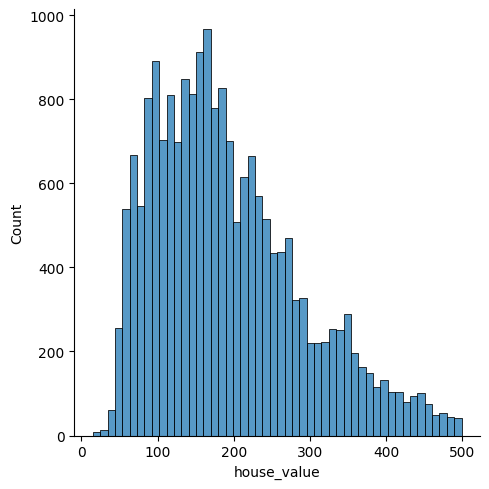

In [54]:
sns.displot(y)

(3930, 8)


<Axes: >

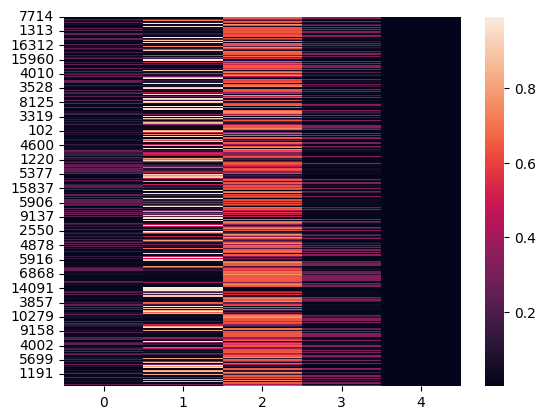

In [55]:
state_mapping = tf.keras.Model(inputs=feat_input, outputs=pred_states)
print(X_ts.shape)
pred_emb = state_mapping(X_ts.values).numpy()
pred_emb = pd.DataFrame(pred_emb, index=X_ts.index)
sns.heatmap(pred_emb)

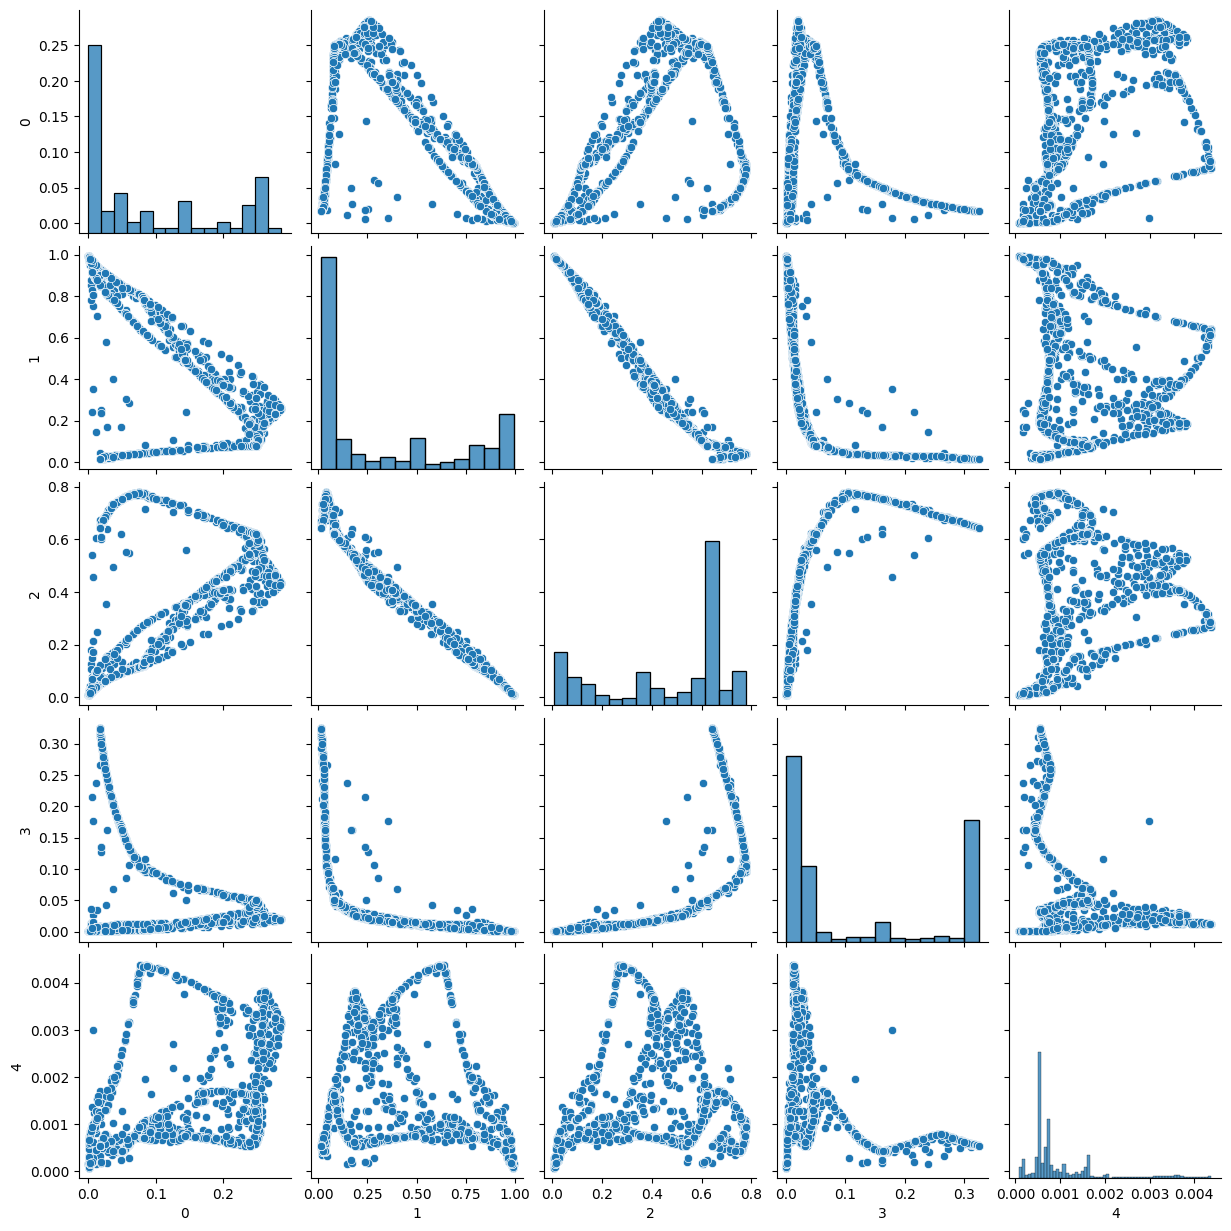

In [56]:
sns.pairplot(pred_emb)

In [57]:
pred_emb.shape

(3930, 5)

In [58]:
utils.col_normalize(pred_emb).sum(axis=0)

state
0    0.999994
1    0.999992
2    0.999994
3    0.999992
4    1.000000
dtype: float32

In [59]:
X_ts.head()

,longitude,latitude,houseage,medinc,avebedrms,averooms,population,aveoccup
7714,-118.209999,34.160000,25.0,434.0,74.0,199.0,75.0,5.9199
5586,-119.330002,35.590000,20.0,3085.0,691.0,2645.0,676.0,1.7868
5596,-117.110001,32.669998,43.0,515.0,146.0,445.0,140.0,1.6094
14265,-122.120003,38.009998,50.0,1738.0,355.0,837.0,363.0,3.6090
12374,-118.180000,33.910000,36.0,1138.0,238.0,878.0,224.0,2.0625


In [60]:
utils.state_size(pred_emb)

state
0     363.133820
1    1297.961914
2    1787.480835
3     477.626251
4       3.806048
dtype: float32

In [61]:
utils.agg_data_by_state(pred_emb, X_ts).round(2)

,longitude,latitude,houseage,medinc,avebedrms,averooms,population,aveoccup
state,,,,,,,,
0,0.09,0.09,0.10,0.08,0.08,0.08,0.08,0.09
1,0.33,0.33,0.32,0.26,0.29,0.33,0.28,0.23
2,0.45,0.45,0.46,0.50,0.48,0.45,0.49,0.52
3,0.12,0.12,0.12,0.16,0.15,0.13,0.15,0.16
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


# Multi-class classification (MNIST)

Example of multi-class classification using MNIST.

In [62]:
digits = sklearn.datasets.load_digits()
n_samples = len(digits.images)
data = digits.images#.reshape((n_samples, -1))

# Split data into 50% train and 50% test subsets
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    data, digits.target, test_size=0.2, shuffle=False
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1437, 8, 8), (360, 8, 8), (1437,), (360,))

In [63]:
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [64]:
loss_fn, act, metrics = _get_loss_activation_metrics(y_train)
loss_fn, act

('sparse_categorical_crossentropy', 'softmax')

In [65]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(64, (4, 4), strides = (2, 2), name = 'conv0', input_shape = (8, 8, 1)))

model.add(tf.keras.layers.BatchNormalization(axis = 3, name = 'bn0'))
model.add(tf.keras.layers.Activation('relu'))

model.add(tf.keras.layers.MaxPooling2D((3, 3), name='max_pool'))
model.add(tf.keras.layers.Conv2D(16, (1, 1), strides = (1,1), name="conv1"))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.AveragePooling2D((1, 1), name='avg_pool'))

model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(50, activation="relu", name='rl'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(layers.PRESS(units=10, n_states=5, activation=act))
model.summary()

/Users/georg/Projects/pypress/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv0 (Conv2D)                  │ (None, 3, 3, 64)       │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn0 (BatchNormalization)        │ (None, 3, 3, 64)       │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pool (MaxPooling2D)         │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 1, 1, 16)       │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 1, 1, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ avg_pool (AveragePooling2D)     │ (None, 1, 1, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 16)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rl (Dense)                      │ (None, 50)             │           850 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ press (PRESS)                   │ (None, 10)             │           305 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,539 (13.82 KB)

 Trainable params: 3,411 (13.32 KB)

 Non-trainable params: 128 (512.00 B)

In [66]:
model.compile(loss=loss_fn, optimizer=tf.keras.optimizers.Nadam(learning_rate=0.02),
             metrics=metrics)

In [67]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10)

Epoch 1/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - categorical_accuracy: 0.1587 - loss: 2.2305 - val_categorical_accuracy: 0.1167 - val_loss: 2.0513
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.0579 - loss: 1.8814 - val_categorical_accuracy: 0.1167 - val_loss: 2.3167
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.0331 - loss: 1.6857 - val_categorical_accuracy: 0.0778 - val_loss: 1.9823
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.0339 - loss: 1.5326 - val_categorical_accuracy: 0.0306 - val_loss: 2.1934
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.0920 - loss: 1.4666 - val_categorical_accuracy: 0.1583 - val_loss: 1.5262
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.0401 - loss: 1.5010 - val_categorical_accuracy: 0.1194 - val_loss: 1.4059
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.0657 - loss: 1.4112 - va

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


<Axes: >

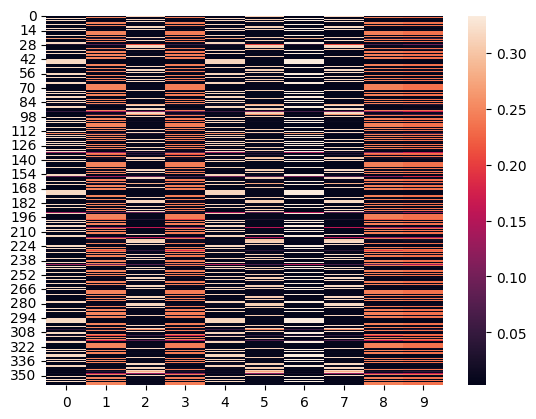

In [68]:
sns.heatmap(pd.DataFrame(model.predict(X_test)))

# Example of single `PRESS()` layer

In [69]:
mod = tf.keras.Sequential()
mod.add(layers.PredictiveStateSimplex(n_states=6, activity_regularizer=regularizers.Uniform(0.01), input_dim=X.shape[1]))
mod.add(layers.PredictiveStateMeans(units=1, activation="sigmoid"))
mod.compile(loss=loss_fn, optimizer=tf.keras.optimizers.Nadam(learning_rate=0.01),
            metrics=metrics)
mod.summary()

/Users/georg/Projects/pypress/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ predictive_state_simplex_3      │ (None, 6)              │            54 │
│ (PredictiveStateSimplex)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictive_state_means_5        │ (None, 1)              │             6 │
│ (PredictiveStateMeans)          │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 60 (240.00 B)

 Trainable params: 60 (240.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
mod.fit(X_tr, y_tr, epochs=2)

In [ ]:
mod = tf.keras.Sequential()
mod.add(layers.PRESS(units=1, n_states=6, activation="sigmoid", activity_regularizer=regularizers.DegreesOfFreedom(l1=0.1, df=2.), input_dim=X.shape[1]))
mod.compile(loss=loss_fn, optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001),
            metrics=metrics)
mod.summary()

In [ ]:
mod.fit(X_tr, y_tr, epochs=12)

In [ ]:
from sklearn.datasets import load_breast_cancer
import sklearn
X, y = load_breast_cancer(return_X_y=True, as_frame=True)
X_s = sklearn.preprocessing.robust_scale(X)  # See demo.ipynb to properly scale X with train/test split


import tensorflow as tf
from pypress.keras import layers
from pypress.keras import regularizers

mod = tf.keras.Sequential()
# see layers.PRESS() for single layer wrapper
mod.add(layers.PredictiveStateSimplex(
            n_states=6,
            activity_regularizer=regularizers.Uniform(0.01),
            input_dim=X.shape[1]))
mod.add(layers.PredictiveStateMeans(units=1, activation="sigmoid"))
mod.compile(loss="binary_crossentropy",
            optimizer=tf.keras.optimizers.Nadam(learning_rate=0.01),
            metrics=[tf.keras.metrics.AUC(curve="PR", name="auc_pr")])
mod.summary()
mod.fit(X_s, y, epochs=10, validation_split=0.2)